In [1]:
import cv2
import rospy
from sensor_msgs.msg import Image, CameraInfo
import numpy as np
from matplotlib import pyplot as plt

In [2]:
aruco_length = 0.12

In [16]:
camera_matrix = np.reshape(np.array([1386.4138492513919, 0.0, 960.5, 0.0, 1386.4138492513919, 540.5, 0.0, 0.0, 1.0]), (3, 3))
camera_distortion = np.reshape(np.array([0.0, 0.0, 0.0, 0.0, 0.0]), (5,))
print("\ncamera matrix:")
print(camera_matrix)
print("\ncamera distortion:")
print(camera_distortion)


camera matrix:
[[1.38641385e+03 0.00000000e+00 9.60500000e+02]
 [0.00000000e+00 1.38641385e+03 5.40500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

camera distortion:
[0. 0. 0. 0. 0.]


In [17]:
img = np.array(cv2.imread('camera.png'))


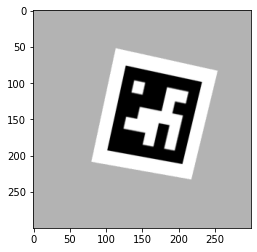

In [18]:
plt.imshow(img[100:400,900:1200,::-1])

In [19]:
(corners, ids, rejected) = cv2.aruco.detectMarkers(img,
                                                   cv2.aruco.Dictionary_get(cv2.aruco.DICT_5X5_1000)) # detect markers

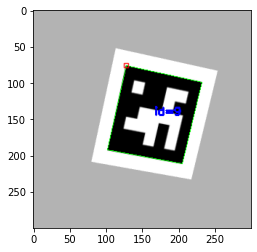

In [20]:
overlay_frame = cv2.aruco.drawDetectedMarkers(img, corners, ids)
img_show = overlay_frame
plt.imshow(img[100:400,900:1200,::-1])

In [21]:
print(ids)

[[1]
 [8]
 [2]
 [9]]


In [22]:
rvecs, tvecs, _objPoints = cv2.aruco.estimatePoseSingleMarkers(corners,aruco_length,
                                                                       camera_matrix,
                                                                       camera_distortion)

In [23]:
for (rvec,tvec) in zip(rvecs,tvecs):
    overlay_frame = cv2.drawFrameAxes(img, camera_matrix, camera_distortion, rvec, tvec, aruco_length)

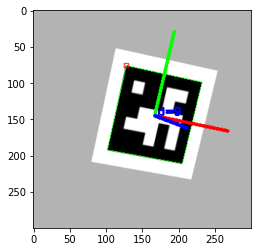

In [24]:
plt.imshow(overlay_frame[100:400,900:1200,::-1])

In [25]:
from pytransform3d.plot_utils import make_3d_axis
import pytransform3d.transformations as tf
import pytransform3d.rotations as rot
from pytransform3d.transform_manager import TransformManager

In [26]:
T_WC = tf.transform_from(rot.passive_matrix_from_angle(1, 0.3), np.array([1,1,1]), strict_check=True)
# 1: axis y - rotation by -0.3 rad around axis y

In [27]:
tm = TransformManager()
tm.add_transform("camera", "world", T_WC)

for id,(rvec,tvec) in enumerate(zip(rvecs,tvecs)):
    T_CM = tf.transform_from(rot.matrix_from_compact_axis_angle(rvec.flatten()), tvec)
    T_corrector = np.array([  [ 0,  0, 1, 0],
                               [ -1, 0, 0, 0],
                               [ 0,  -1, 0, 0],
                               [ 0, 0, 0, 1]])
    tm.add_transform("marker"+str(id), "camera", T_corrector @ T_CM @ np.linalg.inv(T_corrector))
    
# ee2object = tm.get_transform("end-effector", "object")



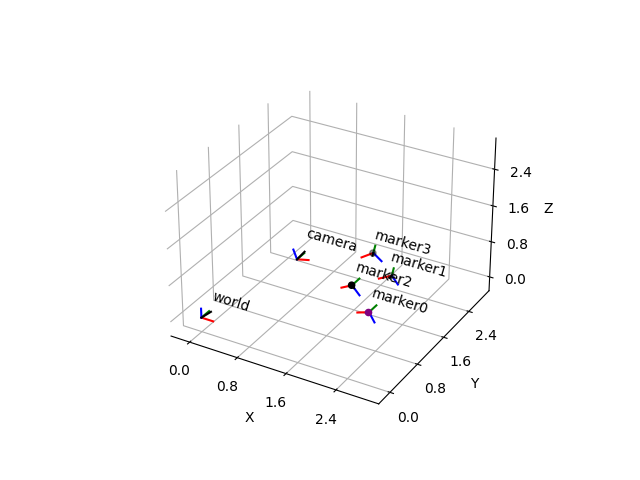

In [28]:
%matplotlib widget
ax = tm.plot_frames_in("world", s=0.2)
ax.set_xlim((-0.25, 3))
ax.set_ylim((-0.25, 3))
ax.set_zlim((-0.25, 3))
ax.scatter([2.4575, 2.5353, 2.2915], [0, 0.9822, 0.8877], [1.7207, 1.2679, 1.7207], c="black")
ax.scatter([2.7189], [0], [1.2679], c="purple")
plt.show()